<a href="https://colab.research.google.com/github/RoyElkabetz/Text-Summarization-with-Deep-Learning/blob/main/notebooks/Text_Classification_full_vs_machine_summarized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## uncomment only if running from google.colab
# clone the git reposetory
!git clone https://github.com/RoyElkabetz/Text-Summarization-with-Deep-Learning
# add path to .py files for import
import sys
sys.path.insert(1, "/content/Text-Summarization-with-Deep-Learning/src")

Cloning into 'Text-Summarization-with-Deep-Learning'...
remote: Enumerating objects: 319, done.
remote: Counting objects: 100% (319/319), done.
remote: Compressing objects: 100% (301/301), done.
remote: Total 319 (delta 168), reused 47 (delta 14), pack-reused 0
Receiving objects: 100% (319/319), 7.61 MiB | 5.30 MiB/s, done.
Resolving deltas: 100% (168/168), done.


In [2]:
## uncomment if you want to mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%matplotlib inline
import time
import pandas as pd

import torch
from torchtext.datasets import IMDB
import torchtext.data as data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split
from torch import nn




print(f'torch {torch.__version__}')
print('Device properties:')
if torch.cuda.is_available():
    device = torch.device("cuda")
    gpu_data = torch.cuda.get_device_properties(0)
    gpu_name = gpu_data.name
    gpu_mem  = f'{gpu_data.total_memory * 1e-9:.02f} Gb'
    print(f'GPU: {gpu_name}\nMemory: {gpu_mem}')
else:
    device = torch.device("cpu")
    print('CPU')

torch 1.9.0+cu102
Device properties:
GPU: Tesla T4
Memory: 15.84 Gb


In [4]:
class DataFrameDataset(Dataset):
  """Create a torch.utils.data.Dataset from a pandas.DataFrame or a CSV file."""

  def __init__(self, csv_file_path=None, pd_dataframe=None, only_columns=None):
    """
      Args:
      csv_file_path (string): Path to the csv file with annotations.
      pd_dataframe (Pandas DataFrame): A Pandas DataFrame with containing the
      data.
      only_columns (list): A List of colums names from the data. 
    """
    if isinstance(pd_dataframe, pd.DataFrame):
      self.df = pd_dataframe 
    else:
      self.df = pd.read_csv(csv_file_path)

    if only_columns is not None:
      if isinstance(only_columns, list):
        for item in only_columns:
          if item not in self.df.columns:
            raise ValueError(f"Got a column name '{item}' in only_columns which is not in DataFrame columns.")
        self.only_columns = only_columns
      else:
        raise TypeError(f"only_columns must be a <class 'list'>, instead got a {type(only_columns)}.")
    else:
      self.only_columns = list(self.df.columns)

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx][self.only_columns]
    row_list = [item for item in row]
    return row_list

## Get the IMDB dataset and create a vocabulary from the train dataset
I use the IMDB test data as train

In [5]:
tokenizer = get_tokenizer('basic_english')
train_iter = IMDB(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>", "<sos>", "<eos>"])
vocab.set_default_index(vocab["<unk>"])

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:00<00:00, 93.3MB/s]


## Create text and labels pipelines

In [6]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: 0 if x=='neg' else 1

## Print some random samples and the size of the dataset

In [7]:
train_iter = IMDB(split='train')
n_samples = len(train_iter)
random_list = torch.randint(0, n_samples - 1, (4, ))
labels = []
for i, (label, text) in enumerate(train_iter):
    labels.append(label)
    if i in random_list:
        print(f'Label: {label_pipeline(label)}')
        print(f'Text: {text}')
        print(f'Split: {tokenizer(text)}')
        print(f'Tokens: {text_pipeline(text)}\n')
print('Number of classes: {}'.format(len(set(labels))))
print('Number of samples: {}'.format(n_samples))

Label: 1
Text: The Lion King 1 1/2 is a very cute story to go along with The Lion King. It basically follows the original story of The Lion King but with a couple of twists. In the movie,e vents are explained by a different characters point of view. This story is still an original plot.<br /><br />As far as sequels go, Disney isn't all that great at making worthwhile ones. This one, being the third part to The Lion King (Simba's Pride is the second.) actually has an original idea to it while still involving the fun of the first. Timon and Pumbaa travel along looking for the ideal place to live. After searching far and wide, they find the place of "Hakuna Matata". They then meet a small lion named Simba, and go through many things that parents today go through.<br /><br />I think this is a very good movie, and I'm happy to add it to my collection.
Split: ['the', 'lion', 'king', '1', '1/2', 'is', 'a', 'very', 'cute', 'story', 'to', 'go', 'along', 'with', 'the', 'lion', 'king', '.', 'it',

In [33]:
TRAIN_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB/train.csv'
VALID_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB/valid.csv'
TEST_DATASET_PATH = '/content/gdrive/MyDrive/Datasets/Text/IMDB/test.csv'

all_test_datasets = pd.read_csv(TEST_DATASET_PATH)
all_test_datasets = all_test_datasets.drop(['Unnamed: 0'], axis=1)
all_test_datasets.head()

,label,text,summary-150,summary-128,summary-64,summary-32,summary-16,summary-8,summary-4
0,neg,I love sci-fi and am willing to put up with a ...,"Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', the original Star Trek ...","Actors of 'Babylon 5', which is",Actors of 'B,Actors
1,neg,"Worth the entertainment value of a rental, esp...",The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4/5 (Terro...,The film is rated 4/5 (Atlanta) and 4,The film is rated 4/5,The film is
2,neg,its a totally average film with a few semi-alr...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of a very basic type that...,The end plot is that of,The end plot
3,neg,STAR RATING: ***** Saturday Night **** Friday ...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop Jack Robideaux...,Former New Orleans homicide cop,Former New Orleans
4,neg,"First off let me say, If you haven't enjoyed a...",A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,A Van Damme movie is worth watching. It has th...,The Van Damme movie is,A Van Dam


In [21]:
dataframe_columns = all_test_datasets.columns
i = 300
for item in dataframe_columns:
    print(f'#### {item} ####')
    print(all_test_datasets.iloc[i][item])
    print('\n')


#### label ####
neg


#### text ####
I really didn't like this film~!!!! it was boring and didn't interest me that much at all.. i'm more of an action girl, and it had NONE. i went and rented this movie because of the other comment that was left.. but was totally mislead! don't get this movie unless you like the dessert and plenty of boredom. i just really didn't like the movie. it wasn't my style, but it could be yours.. you would just have to watch the previews or something but it's my recommendation if you're a girl.. don't get this movie! This Scandinavian production draws on some of the observational strategies of Godfrey Reggio's Koyaanisqatsi, allowing us to reflect on patterns and phenomena of human and natural existence from both intimate and sweeping viewpoints. this just isn't for me!


#### summary-150 ####
A Scandinavian production company, which focuses on the observational strategies of Godfrey Reggio's Koyaanisqatsi, draws on the observational strategies of Godfrey Regg

In [34]:
train_dataset = DataFrameDataset(csv_file_path=TRAIN_DATASET_PATH, only_columns=['label', 'text'])
valid_dataset = DataFrameDataset(csv_file_path=VALID_DATASET_PATH, only_columns=['label', 'text'])

summary_columns = ['text', 'summary-150', 'summary-128', 'summary-64', 'summary-32', 'summary-16', 'summary-8', 'summary-4']
test_datasets = []
for item in summary_columns:
    dataset_columns = ['label']
    dataset_columns.append(item)
    test_datasets.append(DataFrameDataset(csv_file_path=TEST_DATASET_PATH, only_columns=dataset_columns))

In [35]:
print(f'Validation dataset size is: {len(valid_dataset)}')
for i, test_dataset in enumerate(test_datasets):
    print(f'Test dataset with {summary_columns[i]} has size of: {len(test_dataset)}')

Validation dataset size is: 24000
Test dataset with text has size of: 1000
Test dataset with summary-150 has size of: 1000
Test dataset with summary-128 has size of: 1000
Test dataset with summary-64 has size of: 1000
Test dataset with summary-32 has size of: 1000
Test dataset with summary-16 has size of: 1000
Test dataset with summary-8 has size of: 1000
Test dataset with summary-4 has size of: 1000


In [ ]:
# test_loader = DataLoader(full_test_dataset, batch_size=4, shuffle=True)
# for batch in test_loader:
#   print('Print samples from a single batch:\n')
#   labels, texts, summaries = batch
#   for i in range(len(labels)):
#     print(f'Label: {label_pipeline(labels[i])}')
#     print(f'Text: {texts[i]}')
#     print(f'Summary: {summaries[i]}')
#     print('\n')
#   break

Print samples from a single batch:

Label: 0
Text: This is the worst sequel on the face of the world of movies. Once again it doesn't make since. The killer still kills for fun. But this time he is killing people that are making a movie about what happened in the first movie. Which means that it is the stupidest movie ever.<br /><br />Don't watch this. If you value the one precious hour during this movie then don't watch it. You'll want to ask the director and the person beside you what made him make it. Because it just doesn't combine the original makes of
Summary: This is the worst sequel on the face of the world of movies. Once again it doesn't make since. The killer still kills for fun. But this time he is killing people that are making a movie about what happened in the first movie. Which means that it is the stupidest movie ever.


Label: 1
Text: A stunning film of high quality.<br /><br />Apparently based on true events which, as told, has the clear ring of truth about it, this 

In [29]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(label_pipeline(_label))
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device) 

In [30]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [40]:
num_class = 2
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

In [50]:
def train(dataloader, logger):
    model.train()
    total_acc, total_loss, total_count = 0, 0, 0
    log_interval = 200
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predited_label = model(text, offsets)
        loss = criterion(predited_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predited_label.argmax(1) == label).sum().item()
        total_loss += loss.item()
        total_count += label.size(0)
        logger = update_logger(logger, 'train_loss', total_loss / total_count)
        logger = update_logger(logger, 'train_acc', total_acc / total_count)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader, logger=None):
    model.eval()
    total_acc, total_loss, total_count = 0, 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predited_label = model(text, offsets)
            loss = criterion(predited_label, label)
            total_acc += (predited_label.argmax(1) == label).sum().item()
            total_loss += loss.item()
            total_count += label.size(0)
            if logger is not None:
                logger = update_logger(logger, 'valid_loss', total_loss / total_count)
                logger = update_logger(logger, 'valid_acc', total_acc / total_count)
    return total_acc/total_count

def update_logger(logger, name, value):
    logger[name].append(value)
    return logger


In [44]:
# Hyperparameters
EPOCHS = 20 # epoch
LR = 5  # learning rate
BATCH_SIZE = 32 # batch size for training

logger = {'train_loss': [], 
          'train_acc': [],
          'valid_loss': [],
          'valid_acc': [],
          }  
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.5)
total_accu = None

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(valid_dataset, batch_size=BATCH_SIZE,
                              shuffle=False, collate_fn=collate_batch)




for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader, logger)
    accu_val = evaluate(valid_dataloader, logger)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
      total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   200/  782 batches | accuracy    0.569
| epoch   1 |   400/  782 batches | accuracy    0.695
| epoch   1 |   600/  782 batches | accuracy    0.747
-----------------------------------------------------------
| end of epoch   1 | time: 31.80s | valid accuracy    0.730 
-----------------------------------------------------------
| epoch   2 |   200/  782 batches | accuracy    0.802
| epoch   2 |   400/  782 batches | accuracy    0.812
| epoch   2 |   600/  782 batches | accuracy    0.813
-----------------------------------------------------------
| end of epoch   2 | time: 31.80s | valid accuracy    0.722 
-----------------------------------------------------------
| epoch   3 |   200/  782 batches | accuracy    0.855
| epoch   3 |   400/  782 batches | accuracy    0.852
| epoch   3 |   600/  782 batches | accuracy    0.852
-----------------------------------------------------------
| end of epoch   3 | time: 31.82s | valid accuracy    0.844 
-------------------------------

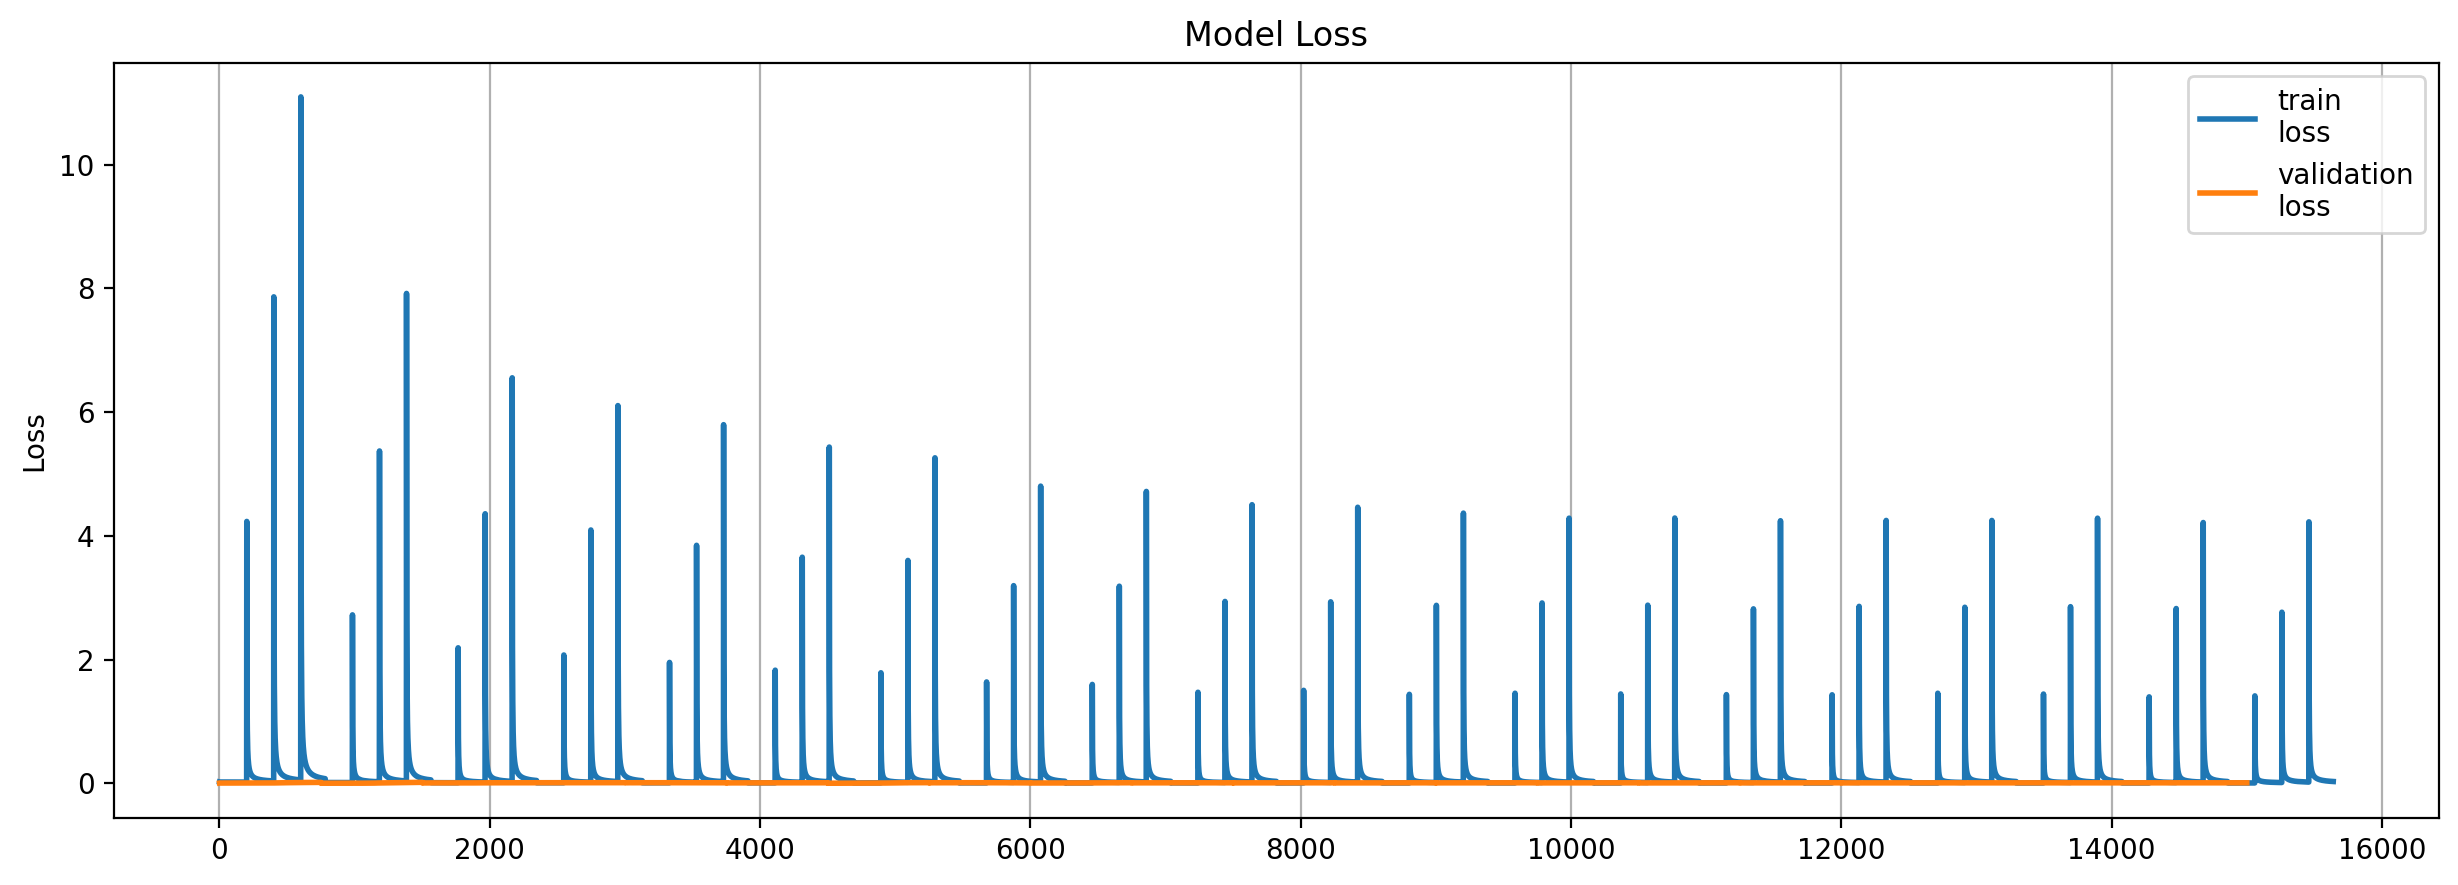

In [47]:
import matplotlib.pylab as plt
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot loss
p1 = ax.plot(range(1, len(logger['train_loss']) + 1), logger['train_loss'], linewidth=2, label='train\nloss')
p2 = ax.plot(range(1, len(logger['valid_loss']) + 1), logger['valid_loss'], linewidth=2, label='validation\nloss')
#ax.set_xticks(range(0, EPOCHS + 1, 2))
#ax.set_xticklabels(range(0, EPOCHS + 1, 2))
#ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Model Loss')
ax.xaxis.grid()
ax.legend()

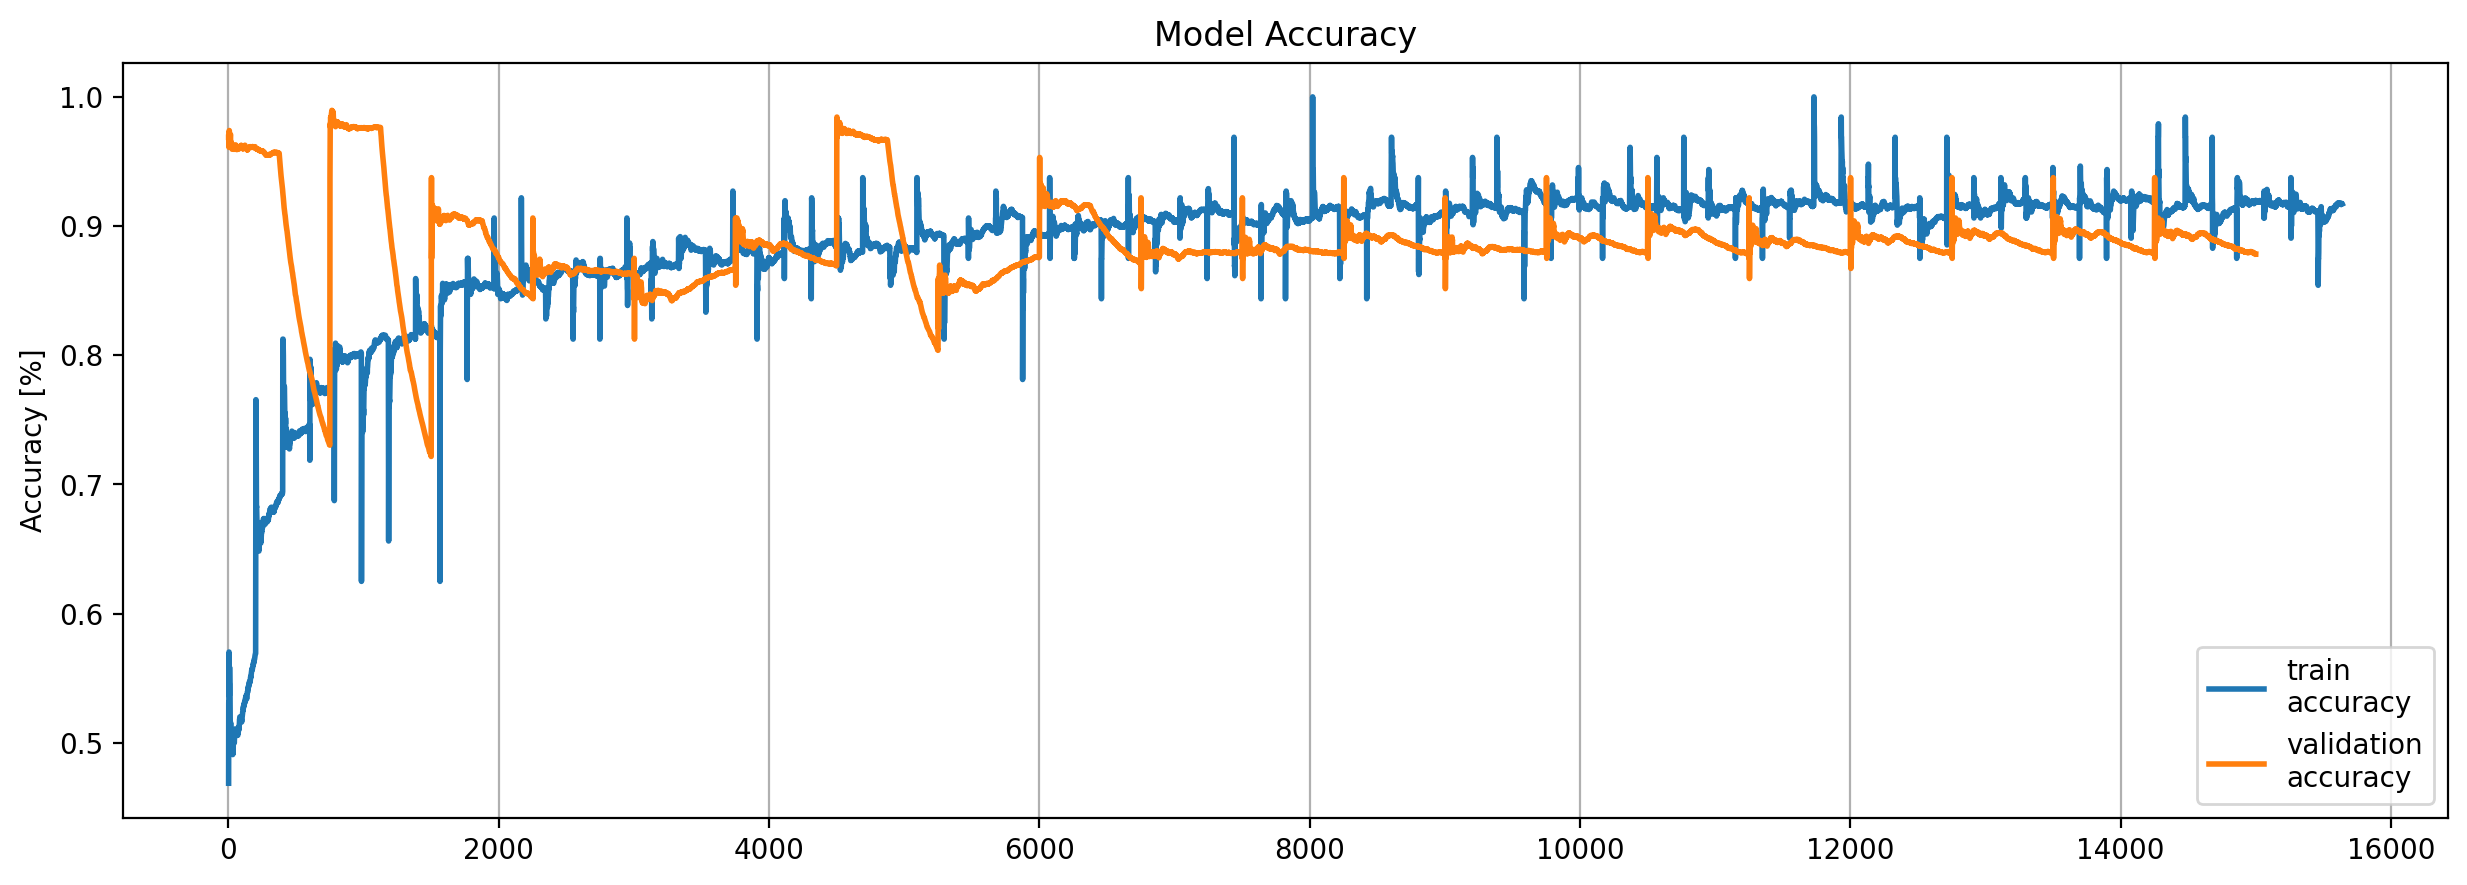

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5), dpi=200)
fig.patch.set_facecolor('white')

# plot loss
p1 = ax.plot(range(1, len(logger['train_loss']) + 1), logger['train_acc'], linewidth=2, label='train\naccuracy')
p2 = ax.plot(range(1, len(logger['valid_acc']) + 1), logger['valid_acc'], linewidth=2, label='validation\naccuracy')
#ax.set_xticks(range(0, EPOCHS + 1, 2))
#ax.set_xticklabels(range(0, EPOCHS + 1, 2))
#ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy [%]')
ax.set_title('Model Accuracy')
ax.xaxis.grid()
ax.legend()

In [51]:
test_accs = []
for i, test_dataset in enumerate(test_datasets):
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                shuffle=False, collate_fn=collate_batch)
    print(f'Checking the results of TEST dataset with data - {summary_columns[i]}:')
    accu_test = evaluate(test_dataloader)
    test_accs.append(accu_test)
    print('accuracy {:8.3f}'.format(accu_test))

Checking the results of TEST dataset with data - text:
accuracy    0.892
Checking the results of TEST dataset with data - summary-150:
accuracy    0.775
Checking the results of TEST dataset with data - summary-128:
accuracy    0.775
Checking the results of TEST dataset with data - summary-64:
accuracy    0.750
Checking the results of TEST dataset with data - summary-32:
accuracy    0.696
Checking the results of TEST dataset with data - summary-16:
accuracy    0.594
Checking the results of TEST dataset with data - summary-8:
accuracy    0.543
Checking the results of TEST dataset with data - summary-4:
accuracy    0.519


In [ ]:
imdb_label = {0: 'negative',
              1: 'positive'}

def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()

ex_positive_str = "Full of suspense, gripping the entire time, intense, \
  two stories in parallel that come together, somewhat predictable betrayals \
   and twist, felt a bit dark at times, satisfying ending, not a huge amount \
    of action but a solid storyline that keeps you on edge."

ex_negative_str = "This is not your traditional Guy Ritchie movie with slick \
   fast paced action, clever humour and lots of twists. Which I have loved in \
    the past. It is basically a combination of heist movie and revenge \
     thriller. But it's played very straight, without a lot of effort to \
      build characters, and doesn't ever seem to build much momentum. So \
       a few times during the movie I found myself looking at my watch, \
        wondering if it was really going anywhere. The action is fairly \
         tight but mainly gunplay, not much physical action as Statham is \
          famous for. There are no heroes either, Stathams character seems  \
          to be a pretty nasty piece of work himself. All in all, it's an \
           average thriller with nothing in particular to recommend it."

model = model.to("cpu")

print("This is a %s review" %imdb_label[predict(ex_positive_str, text_pipeline)])

This is a positive review
